In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from Utility import gradient, gradient_first
from Solver_q import *



In [2]:
f = '/central/groups/esm/zhaoyi/pyqg_run/2layer/beta12rek0p32/beta12rek0p32.100000.nc'
ds = xr.open_dataset(f, engine='h5netcdf')
ds

<xarray.Dataset>
Dimensions:  (lev: 2, k: 129, l: 256, lev_mid: 1, time: 1, y: 256, x: 256)
Coordinates:
  * k        (k) float64 0.0 0.1963 0.3927 0.589 ... 24.54 24.74 24.94 25.13
  * l        (l) float64 0.0 0.1963 0.3927 0.589 ... -0.589 -0.3927 -0.1963
  * lev      (lev) int64 1 2
  * lev_mid  (lev_mid) float64 1.5
  * time     (time) timedelta64[ns] 00:01:40
  * x        (x) float64 0.0625 0.1875 0.3125 0.4375 ... 31.56 31.69 31.81 31.94
  * y        (y) float64 0.0625 0.1875 0.3125 0.4375 ... 31.56 31.69 31.81 31.94
Data variables:
    Qy       (lev) float64 ...
    Ubg      (lev) float64 ...
    ph       (time, lev, l, k) complex128 ...
    q        (time, lev, y, x) float64 ...
    qh       (time, lev, l, k) complex128 ...
    u        (time, lev, y, x) float64 ...
    ufull    (time, lev, y, x) float64 ...
    uh       (time, lev, l, k) complex128 ...
    v        (time, lev, y, x) float64 ...
    vfull    (time, lev, y, x) float64 ...
    vh       (time, lev, l, k) complex128 ...
Attributes: (12/23)
    pyqg:L:          32.0
    pyqg:M:          65536
    pyqg:W:          32.0
    pyqg:beta:       12.0
    pyqg:del2:       0.5
    pyqg:delta:      1.0
    ...              ...
    pyqg:tavestart:  1000
    pyqg:tc:         100000
    pyqg:tmax:       6000
    pyqg:twrite:     50000
    reference:       https://pyqg.readthedocs.io/en/latest/index.html
    title:           pyqg: Python Quasigeostrophic Model

# Load Data

In [3]:
Ny = 256
L = 32
H = [1.0, 1.0]               # the rest depths of each layer
lam = 0.25
beta = 10.0
mu = 0.32                     # bottom drag
U = [1.0, -1.0]
dU = U[0] - U[1] 
F1 = 2.0/lam**2
F2 = 2.0/lam**2
beta1, beta2 = beta + F1*dU, beta - F2*dU
hyper_nu, hyper_order = 0.0, 2


file_name = 'beta12rek0p32'
pre_file  = '/central/groups/esm/zhaoyi/pyqg_run/2layer/' + file_name + '/'

start, end, step = 3000000, 6000000, 20000
u, v, q, psi = load_netcdf(pre_file, file_name, start, end, step)


# u = np.load(pre_file + "u_data.npy")
# v = np.load(pre_file + "v_data.npy")
# q = np.load(pre_file + "q_data.npy")
# psi = np.load(pre_file + "psi_data.npy")
nt, nx, ny, nlayers = u.shape


q_zonal_mean   = np.mean(q, axis = 1)
psi_zonal_mean = np.mean(psi, axis = 1)
dq_zonal_mean  = np.copy(q_zonal_mean)



yy, dy = np.linspace(0, L - L/ny, ny), L/ny

flux_zonal_mean = np.mean(v * q, axis = 1)
for i in range(nt):
    for j in range(nlayers):
        dq_zonal_mean[i, :, j] = gradient_first(q_zonal_mean[i, :, j], dy)


dpv_zonal_mean =  np.copy(dq_zonal_mean)
dpv_zonal_mean[:,:, 0] += beta1
dpv_zonal_mean[:,:, 1] += beta2



# Plot zonal mean q

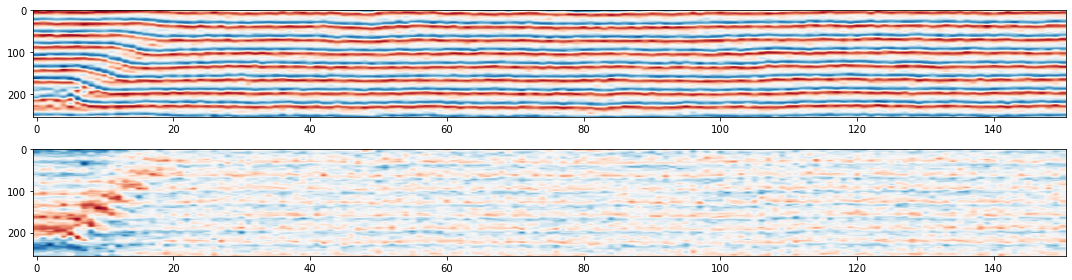

In [4]:
fig, ax = plt.subplots(2,figsize=(15,4))
ax[0].imshow(q_zonal_mean[:,:,0].T,  aspect='auto', cmap='RdBu_r')
ax[1].imshow(q_zonal_mean[:,:,1].T,  aspect='auto', cmap='RdBu_r')
plt.tight_layout()

# Plot zonal mean dq

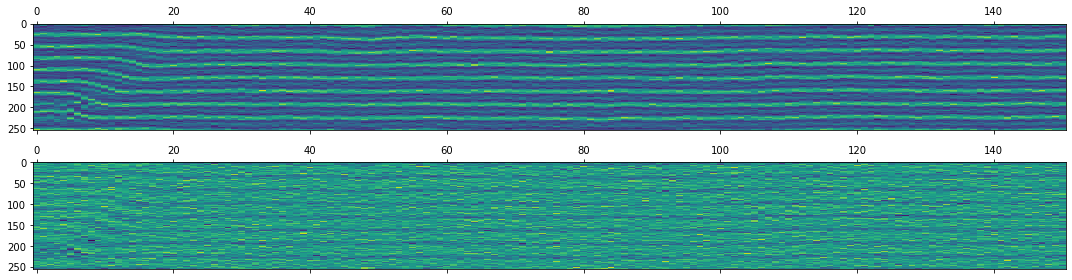

In [5]:
fig, ax = plt.subplots(2,figsize=(15,4))
ax[0].matshow(dq_zonal_mean[:,:,0].T,  aspect='auto')
ax[1].matshow(dq_zonal_mean[:,:,1].T,  aspect='auto')
plt.tight_layout()

# Plot top layer time and zonal mean dpv, flux, mu, q

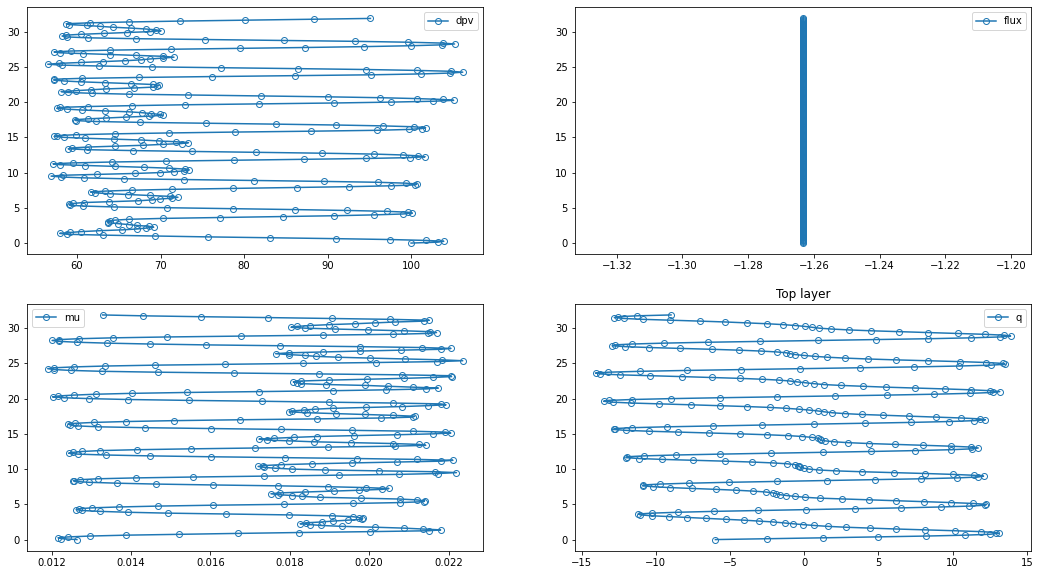

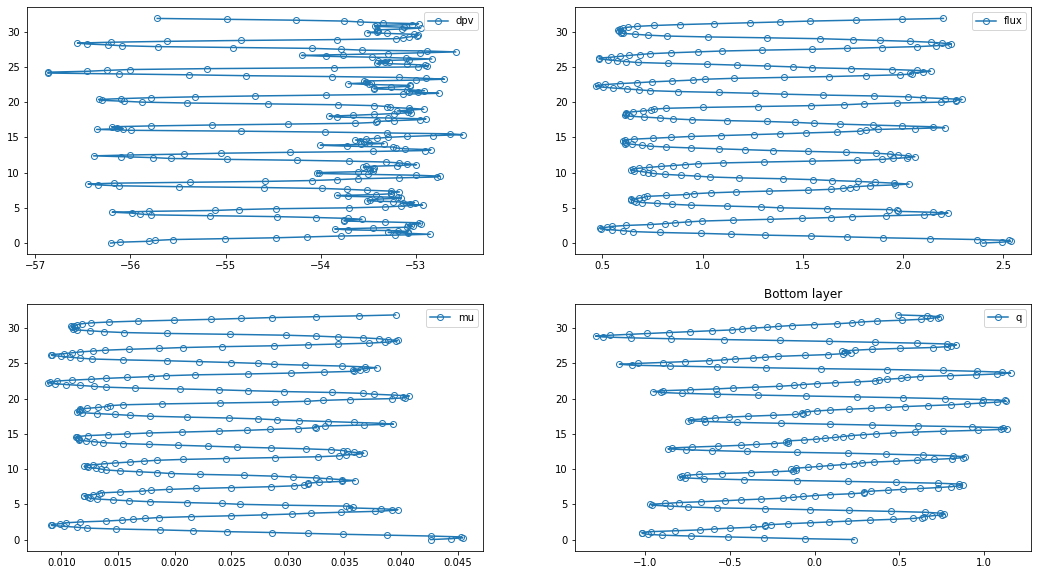

In [18]:
for i in [0]:
    layer = 0
    t_mean_steps = range(i,nt)
    flux_mean    = np.mean(flux_zonal_mean[t_mean_steps, :, :], axis = 0)
    flux_mean[:, 0] = np.mean(flux_mean[:, 0])
    dpv_mean     = np.mean(dpv_zonal_mean[t_mean_steps, :, :],  axis = 0)
    q_mean       = np.mean(q_zonal_mean[t_mean_steps, :, :],    axis = 0)

    
    mu_mean = -flux_mean / dpv_mean
    fig, ax = plt.subplots(2,2,figsize=(18,10))
    ax[0,0].plot(dpv_mean[:, 0], yy, "-o", fillstyle = "none", label="dpv")
    ax[0,0].legend()
    ax[0,1].plot(flux_mean[:, 0], yy, "-o", fillstyle = "none", label="flux")
    ax[0,1].legend()
    ax[1,0].plot(mu_mean[:, 0], yy, "-o", fillstyle = "none", label="mu")
    ax[1,0].legend()
    ax[1,1].plot(q_mean[:, 0], yy, "-o", fillstyle = "none", label="q")
    ax[1,1].legend()
    plt.title("Top layer")
    
    
    fig, ax = plt.subplots(2,2,figsize=(18,10))
    ax[0,0].plot(dpv_mean[:, 1], yy, "-o", fillstyle = "none", label="dpv")
    ax[0,0].legend()
    ax[0,1].plot(flux_mean[:, 1], yy,"-o", fillstyle = "none", label="flux")
    ax[0,1].legend()
    ax[1,0].plot(mu_mean[:, 1], yy,"-o", fillstyle = "none", label="mu")
    ax[1,0].legend()
    ax[1,1].plot(q_mean[:, 1], yy,"-o", fillstyle = "none", label="q")
    ax[1,1].legend()
    plt.title("Bottom layer")

# Plot bottom layer time and zonal mean dpv, flux, mu, q

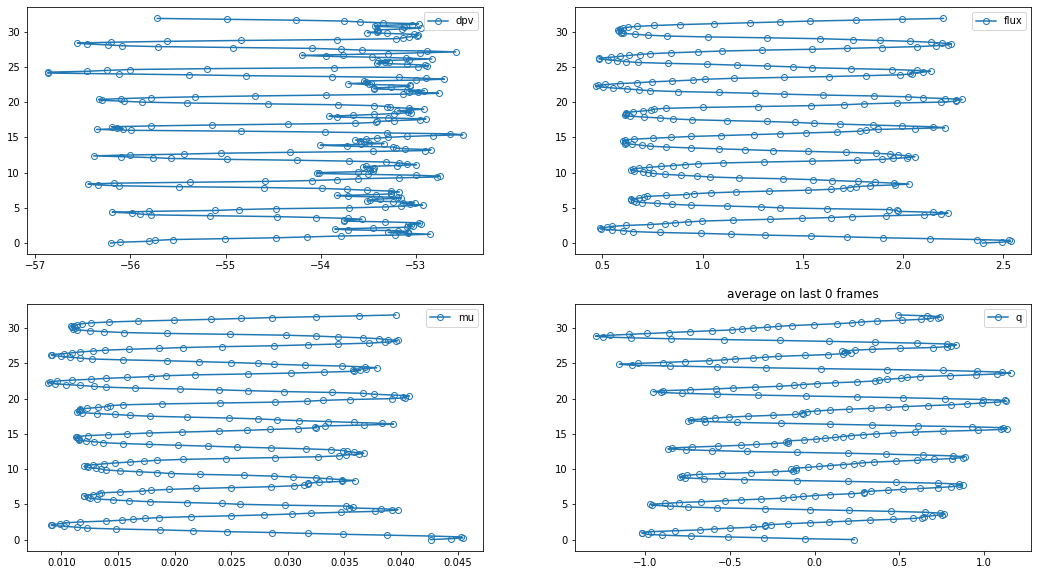

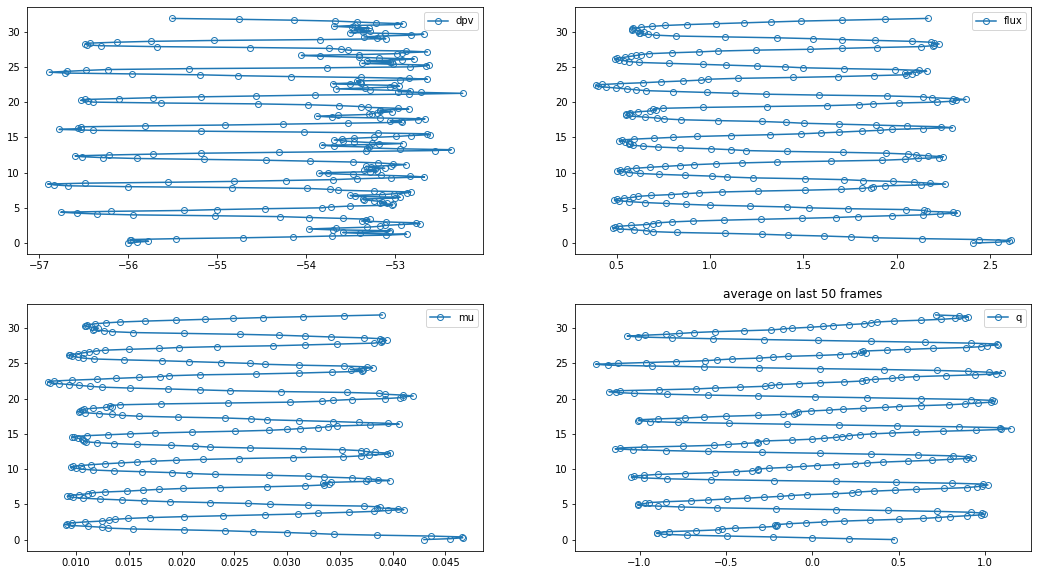

In [7]:
for i in [0,nt//3]:
    layer = 1
    t_mean_steps = range(i, nt)
    flux_mean    = np.mean(flux_zonal_mean[t_mean_steps, :, :], axis = 0)
    dpv_mean     = np.mean(dpv_zonal_mean[t_mean_steps, :, :],  axis = 0)
    q_mean       = np.mean(q_zonal_mean[t_mean_steps, :, :],    axis = 0)
    psi_mean     = np.mean(psi_zonal_mean[t_mean_steps, :, :],    axis = 0)
    
    dpsi_mean_dy = np.copy(psi_mean)
    dpsi_mean_dy[:, 0] = gradient_first(psi_mean[:, 0], dy)
    dpsi_mean_dy[:, 1] = gradient_first(psi_mean[:, 1], dy)
    
    mu_mean = -flux_mean / dpv_mean
    
    fig, ax = plt.subplots(2,2,figsize=(18,10))
    ax[0,0].plot(dpv_mean[:, layer], yy, "-o", fillstyle = "none", label="dpv")
    ax[0,0].legend()
    ax[0,1].plot(flux_mean[:, layer], yy,"-o", fillstyle = "none", label="flux")
    ax[0,1].legend()
    ax[1,0].plot(mu_mean[:, layer], yy,"-o", fillstyle = "none", label="mu")
    ax[1,0].legend()
    ax[1,1].plot(q_mean[:, layer], yy,"-o", fillstyle = "none", label="q")
    ax[1,1].legend()
    plt.title("average on last %d frames" %i)

# Test flux budget with exact solution

psi error =  4.0071687900667685


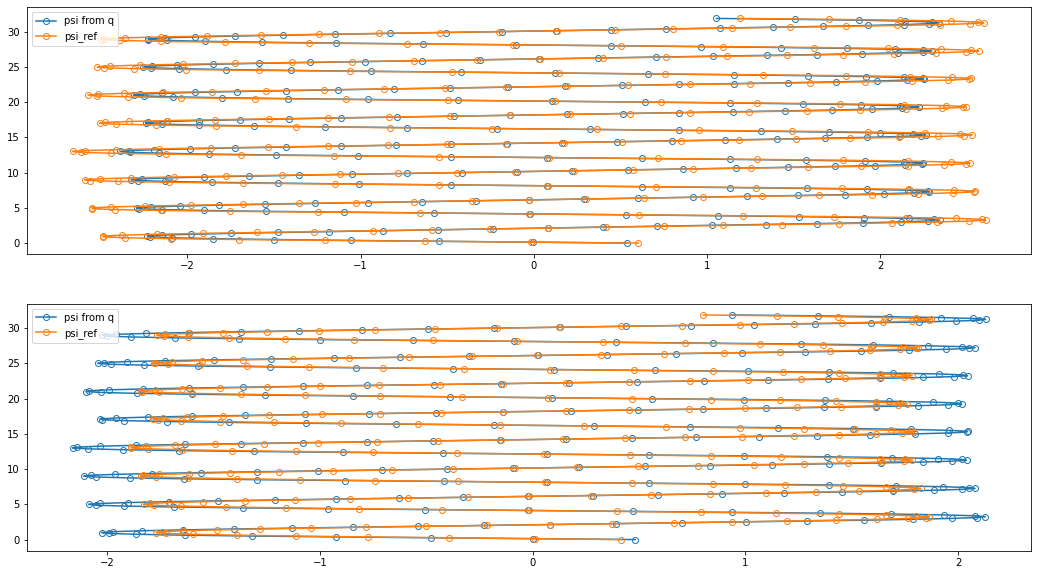

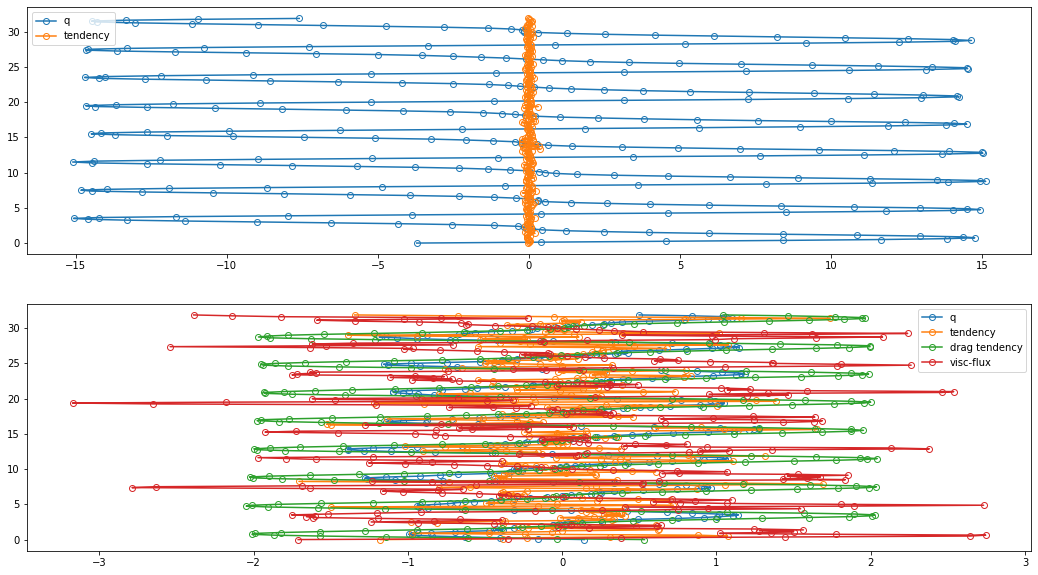

In [8]:
# Test bottom layer
last_n_outputs = nt//3
yy, dy = np.linspace(0, L - L/ny, ny), L/ny

psi_zonal_mean = np.mean(psi, axis = 1)
q_zonal_mean = np.mean(q, axis = 1)
dq_zonal_mean = np.copy(q_zonal_mean)
flux_zonal_mean = np.mean(v * q, axis = 1)
for i in range(nt):
    for j in range(nlayers):
        dq_zonal_mean[i, :, j] = gradient_first(q_zonal_mean[i, :, j], dy)


dpv_zonal_mean = np.copy(dq_zonal_mean)
dpv_zonal_mean[:, :, 0] =  dq_zonal_mean[:, :, 0] + beta1
dpv_zonal_mean[:, :, 1] =  dq_zonal_mean[:, :, 1] + beta2

t_mean_steps = range(-last_n_outputs,-1)
flux_mean    = np.mean(flux_zonal_mean[t_mean_steps, :, :], axis = 0)
dpv_mean     = np.mean(dpv_zonal_mean[t_mean_steps, :, :], axis = 0)
flux_mean[:, 0] = np.mean(flux_mean[:, 0])

q_mean =  np.mean(q_zonal_mean[t_mean_steps, :, :], axis = 0)
psi_mean = np.mean(psi_zonal_mean[t_mean_steps, :, :], axis = 0)
mu_mean = flux_mean / dpv_mean
mu_mean = mu_mean.T

mu_c = np.copy(mu_mean)
mu_c[0,:] = interpolate_f2c(mu_mean[0,:])
mu_c[1,:] = interpolate_f2c(mu_mean[1,:])


params = {
    "L":    L,
    "dU":   dU,
    "beta": beta,
    "mu":   mu,
    "F1":   F1,
    "F2":   F2,
    "nu":   hyper_nu,
    "hyperdiffusion_order": hyper_order
    }
# compute tendency
tend_model = -nummodel(q_mean.T, yy, params, mu_c) 
tend_hyper = hyperdiffusion(q_mean.T, hyper_nu, hyper_order, dy)
psi_fft_mean = psi_fft_sol(q_mean.T, F1, F2, dy)


fig, ax = plt.subplots(2,figsize=(18,10))
ax[0].plot(psi_fft_mean[0, :], yy, "-o", fillstyle = "none", label="psi from q")
ax[0].plot(psi_mean[:, 0], yy, "-o", fillstyle = "none", label="psi_ref")
ax[0].legend()
ax[1].plot(psi_fft_mean[1, :], yy, "-o", fillstyle = "none", label="psi from q")
ax[1].plot(psi_mean[:, 1], yy, "-o", fillstyle = "none", label="psi_ref")
ax[1].legend()

print("psi error = ", np.linalg.norm(psi_fft_mean - psi_mean.T))



dd_psi2 = gradient(psi_fft_mean[1, :], dy, 2)
tend_drag  = -mu*dd_psi2


fig, ax = plt.subplots(2,figsize=(18,10))
ax[0].plot(q_mean[:, 0], yy, "-o", fillstyle = "none", label="q")
ax[0].plot(tend_model[0, :], yy, "-o", fillstyle = "none", label="tendency")
ax[0].legend()
ax[1].plot(q_mean[:, 1], yy,"-o", fillstyle = "none", label="q")
ax[1].plot(tend_model[1, :] + tend_drag, yy, "-o", fillstyle = "none", label="tendency")
ax[1].plot(tend_drag, yy, "-o", fillstyle = "none", label="drag tendency")
ax[1].plot(tend_model[1, :], yy, "-o", fillstyle = "none", label="visc-flux")
ax[1].legend()
    

# print("top model tend = ", tend_model[0, :])
# print("top hyper tend = ", tend_hyper[0,:])
# print("bottom model tend = ", tend_model[1, :] + tend_drag)
# print("bottom model 1 = ", tend_model[1, :])
# print("bottom model 2 = ", tend_drag)

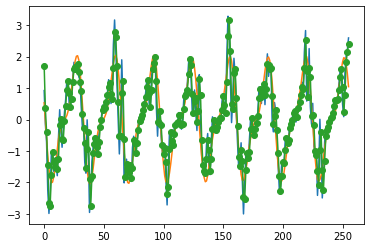

In [9]:
beta, dU, F1, F2 = params["beta"], params["dU"], params["F1"], params["F2"]
beta1, beta2 = beta + F1*dU, beta - F2*dU

# beta1, beta2 = beta + F1*dU, beta + F2*dU

dy = yy[1] - yy[0]

q1, q2 = q_mean.T[0, :], q_mean.T[1, :]
dq1, dq2 = gradient_first_f2c(q1, dy), gradient_first_f2c(q2, dy)


# plt.plot(dq2 + beta2)
# plt.plot(dpv_mean[:,1])
# plt.plot(flux_mean[:,1])

dflux = gradient_first_f2c(flux_mean[:,1], dy)
plt.plot(dflux)
plt.plot(tend_drag)
plt.plot(-tend_model[1, :], "-o")

Text(0.5, 1.0, 'plug in tend')

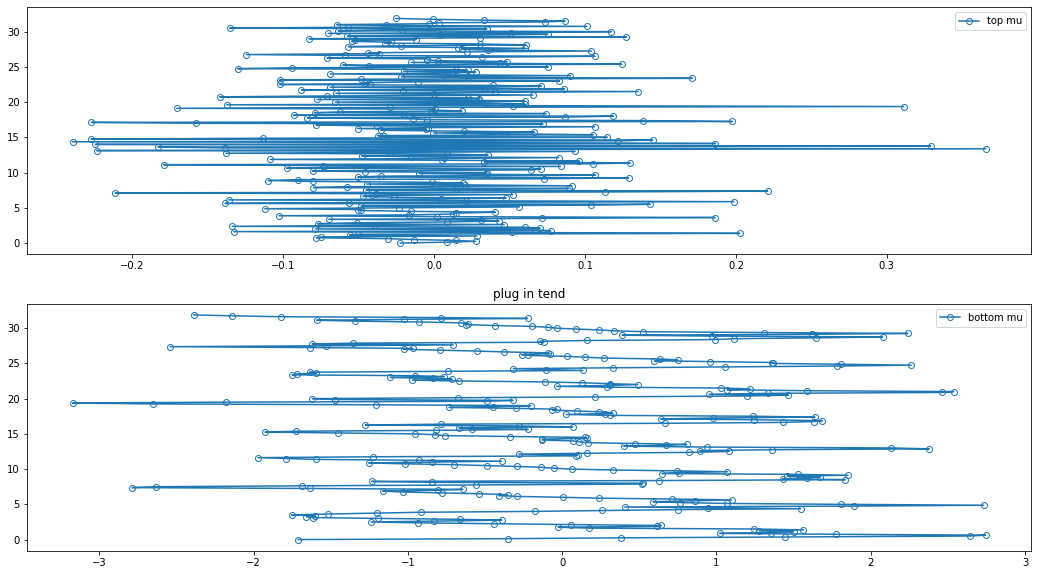

In [10]:
fig, ax = plt.subplots(2,figsize=(18,10))
ax[0].plot(tend_model[0, :], yy, "-o", fillstyle = "none", label="top mu")
ax[0].legend()
ax[1].plot(tend_model[1, :], yy, "-o", fillstyle = "none", label="bottom mu")
ax[1].legend()
plt.title("plug in tend")

# Start 1D plug-in simulation

Text(0.5, 1.0, 'plug in mu')

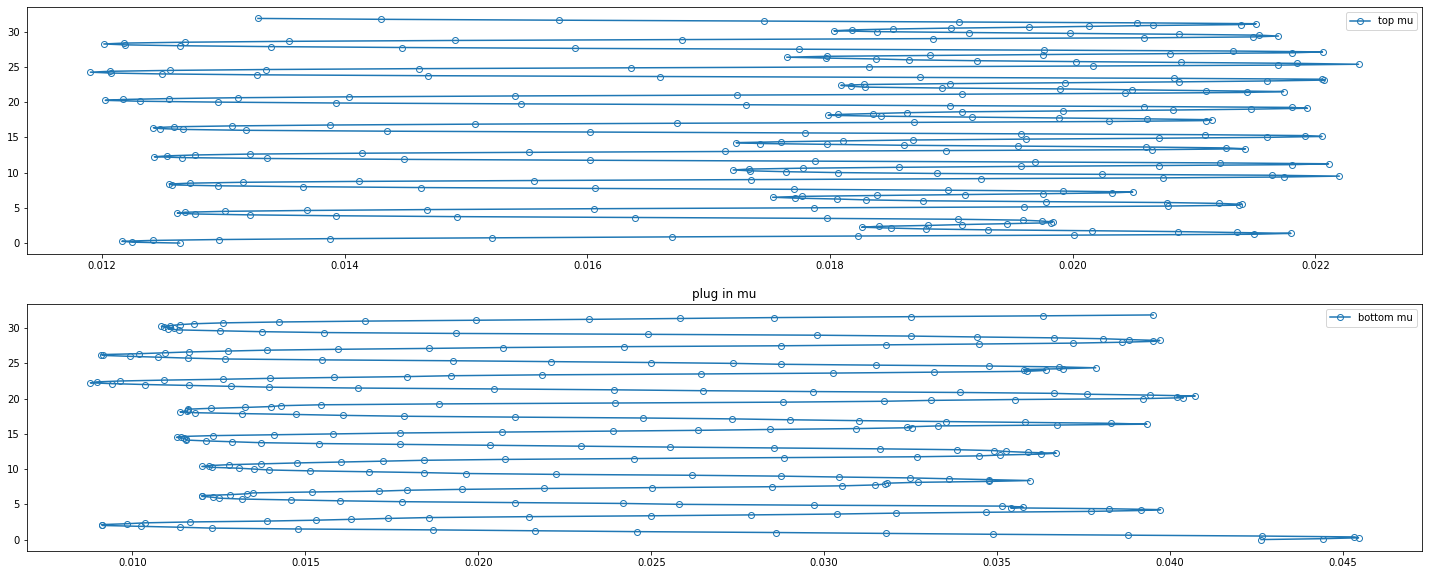

In [21]:
mu_mean = postprocess_mu_pyqg(pre_file,file_name, start, end, step,  L, beta1, beta2)

fig, ax = plt.subplots(2,figsize=(25,10))
ax[0].plot(-mu_mean[0, :], yy, "-o", fillstyle = "none", label="top mu")
ax[0].legend()
ax[1].plot(-mu_mean[1, :], yy, "-o", fillstyle = "none", label="bottom mu")
ax[1].legend()
plt.title("plug in mu")

# 1D solve with q_init =  q_mean

In [26]:
from Solver_q import *

mu_mean_clip = np.copy(mu_mean)
mu_mean_clip[mu_mean_clip > 0] = 0.0

# mu_mean_clip[1, :] -= min(mu_mean_clip[1, :])

save_every = 1000
save_every = 1000
dt = 1e-3
Nt = 20000 #4000*10


# q0 = np.zeros((2, Ny))
# q0[0, :] = 1e-2 * np.sin(2*np.pi*yy/L)
# q0[1, :] = 1e-2 * np.cos(2*np.pi*yy/L)

q0 = np.copy(q_mean.T)
    
y_sol, t_sol, q_sol = solve_q(Ny, L, F1, F2, beta, mu, dU, hyper_nu, hyper_order, q0,
            dt, Nt, save_every,
            "nummodel", mu_mean_clip)

1000 max q 13.856887950752997
2000 max q 13.822004471193615
3000 max q 13.79695877680398
4000 max q 13.77740096824879
5000 max q 13.76143368285004
6000 max q 13.748041681363851
7000 max q 13.73659794742558
8000 max q 13.726681098768175
9000 max q 13.71799194570897
10000 max q 13.710309241358168
11000 max q 13.703464034947752
12000 max q 13.697323955787354
13000 max q 13.691783168543832
14000 max q 13.686755706218863
15000 max q 13.68217088138523
16000 max q 13.677970016377897
17000 max q 13.674104037912477
18000 max q 13.670531657488462
19000 max q 13.667217962239961
20000 max q 13.66413330265931


In [25]:
q_mean_ref = q_mean
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.plot(q_mean_ref[:, 0], yy, label="top ref")
ax.plot(q_mean_ref[:, 1], yy, label="bottom ref")

ax.plot(np.mean(q_sol[Nt//(2*save_every):, 0, :], axis=0), y_sol, "--", label="top")
ax.plot(np.mean(q_sol[Nt//(2*save_every):, 1, :], axis=0), y_sol, "--", label="bottom")

# ax.plot(mu_mean[1, :]*1000, yy, "-o", fillstyle = "none", label="bottom mu")

ax.legend()
plt.title("average on last 1000 frames")

(2, 256)

# 1D solve with q_init =  random sin

In [31]:
from Solver_q import *

mu_mean_clip = np.copy(mu_mean)
mu_mean_clip[mu_mean_clip > 0] = 0.0

# mu_mean_clip[1, :] -= min(mu_mean_clip[1, :])

save_every = 1000
save_every = 1000
dt = 1e-3
Nt = 40000*10

q0 = np.zeros((2, Ny))
q0[0, :] = 1e-1 * np.sin(2*np.pi*yy/L)
q0[1, :] = 1e-1 * np.cos(2*np.pi*yy/L)
    
y_sol, t_sol, q_sol = solve_q(Ny, L, F1, F2, beta, mu, dU, hyper_nu, hyper_order, q0,
            dt, Nt, save_every,
            "nummodel", mu_mean_clip)

1000 max q 1.7361382429778787
2000 max q 2.7593836159712333
3000 max q 3.4572826702889743
4000 max q 3.9591015736317137
5000 max q 4.297411109879963
6000 max q 4.513344825309493
7000 max q 4.890171625263183
8000 max q 5.338777478607222
9000 max q 5.7499256287942435
10000 max q 6.128465234742594
11000 max q 6.478406101902416
12000 max q 6.803106547084717
13000 max q 7.10540548982536
14000 max q 7.387719553757162
15000 max q 7.652117230650887
16000 max q 7.900377246642418
17000 max q 8.13403551370205
18000 max q 8.354423484052717
19000 max q 8.562699813682757
20000 max q 8.759876690390762
21000 max q 8.946841833452321
22000 max q 9.124376940131551
23000 max q 9.293173191900244
24000 max q 9.453844314236997
25000 max q 9.606937593328393
26000 max q 9.752943182066861
27000 max q 9.892301970991653
28000 max q 10.025412253731359
29000 max q 10.152635378685634
30000 max q 10.274300547424568
31000 max q 10.390708894319227
32000 max q 10.502136960278031
33000 max q 10.608839655384712
34000 max 

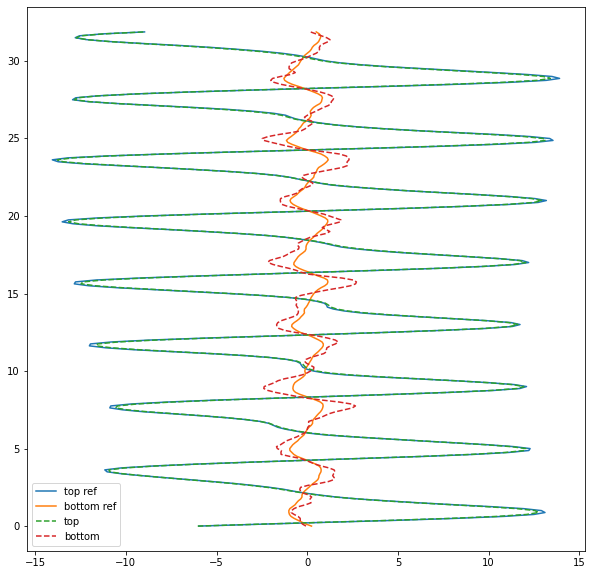

In [33]:
q_mean_ref = q_mean
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.plot(q_mean_ref[:, 0], yy, label="top ref")
ax.plot(q_mean_ref[:, 1], yy, label="bottom ref")

ax.plot(np.mean(q_sol[Nt//(2*save_every):, 0, :], axis=0), y_sol, "--", label="top")
ax.plot(np.mean(q_sol[Nt//(2*save_every):, 1, :], axis=0), y_sol, "--", label="bottom")

ax.legend()